In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

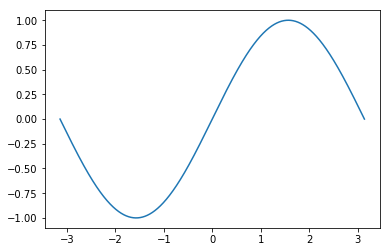

In [4]:
x = np.arange(-math.pi, math.pi, 0.0001)
y = np.sin(x)
plt.plot(x, y)
plt.show()